

### **Adaptive Sampling Principle**

The algorithm adjusts the number of sampled directions on the unit sphere depending on the momentum transfer ( q ).
At small ( q ), fewer orientations are needed because the scattering pattern varies slowly with direction.
At larger ( q ), the pattern becomes more oscillatory, requiring finer angular resolution.

### **Sampling Rule**

For each ( q ), the number of orientations $N$ used for fibonacci sampling is defined by:

$
N(q) = \text{clip}\left( n_\text{base} \left(\frac{q}{q_\text{ref}}\right)^{p}
; n_\text{min}; n_\text{max} \right)
$

* `n_base` sets the sampling density near `q_ref`
* `p` controls how quickly the resolution increases with ( q )
* `n_min` and `n_max` enforce global bounds

This produces **smooth, continuous refinement** of angular sampling with no sudden jumps.

### **Directional Grid**

For each required value of ( N(q) ), a **Fibonacci sphere grid** is generated.
This grid provides an approximately uniform distribution of points on the sphere and is reused for all ( q ) values that require the same number of orientations.




In [1]:
%matplotlib widget
import numpy as np
from numba import njit, prange
import math
from ase.cluster import Decahedron
import matplotlib.pyplot as plt

import numpy as np
from numba import njit, prange
import math

from compute_f0 import f0_from_Q, load_elements_yaml

def fibonacci_sphere(n_points):
    """Génère une grille de Fibonacci sur la sphère"""
    phi = (1 + np.sqrt(5)) / 2
    indices = np.arange(n_points)
    theta = 2 * np.pi * indices / phi
    z = 1 - (2 * indices + 1) / n_points
    radius = np.sqrt(1 - z**2)
    x = radius * np.cos(theta)
    y = radius * np.sin(theta)
    return np.column_stack([x, y, z])

def build_fibonacci_data(
    q_vals,
    n_base=400, q_ref=0.5, scaling_power=0.5,
    n_min=150, n_max=10000
):
    """
    Computes only the necessary Fibonacci sphere grids for the q-values
    and returns Numba-friendly (keys, values) containers.
    """
    # Determine required n_orient values
    needed = set()
    for q in q_vals:
        n = int(n_base * (q / q_ref) ** scaling_power)
        n = min(max(n, n_min), n_max)
        needed.add(n)

    # Build keys and values
    fibo_keys = np.array(sorted(needed), dtype=np.int64)
    fibo_vals = [fibonacci_sphere(n) for n in fibo_keys]

    return fibo_keys, fibo_vals

def plot_nbpoints_qvals(q_vals,
    n_base=400, q_ref=0.75, scaling_power=0.5,
    n_min=150, n_max=10000):
    """
    Computes only the necessary Fibonacci sphere grids for the q-values
    and returns Numba-friendly (keys, values) containers.
    """
    # Determine required n_orient values
    n_list=[]
    for q in q_vals:
        n = int(n_base * (q / q_ref) ** scaling_power)
        n = min(max(n, n_min), n_max)
        n_list.append(n)
    plt.figure()
    plt.semilogx(q_vals,n_list)
    plt.xlabel('q_values')
    plt.ylabel('Number of points in Fibonacci sampling')
    return

    

@njit(parallel=True, fastmath=True)
def compute_intensity_fibonacci_scaling(
    positions, f_q, q_vals,
    fibo_keys, fibo_vals,
    n_base=400, q_ref=0.75, scaling_power=0.5,
    n_min=150, n_max=10000):

    n_atoms = positions.shape[0]
    n_q = len(q_vals)
    Iq = np.zeros(n_q)

    for iq in prange(n_q):
        q = q_vals[iq]
        f = f_q[iq]

        # compute n_orient
        n_orient = int(n_base * (q / q_ref)**scaling_power)
        n_orient = min(max(n_orient, n_min), n_max)

        # find matching Fibonacci grid
        idx = 0
        for k in range(len(fibo_keys)):
            if fibo_keys[k] == n_orient:
                idx = k
                break

        dirs = fibo_vals[idx]

        I_sum = 0.0
        for io in range(n_orient):
            qx, qy, qz = q * dirs[io, :]
            

            Re = 0.0
            Im = 0.0

            for ia in range(n_atoms):
                phase = (qx * positions[ia, 0] +
                         qy * positions[ia, 1] +
                         qz * positions[ia, 2])

                Re += math.cos(phase)
                Im += math.sin(phase)

            I_sum += Re*Re + Im*Im

        Iq[iq] = (I_sum / n_orient) * (f*f)

    return Iq

def compute_isotropic_intensity_adaptative_fibonacci(
    positions, f_q, q_vals,
    n_base=400, q_ref=0.75, scaling_power=0.5,
    n_min=150, n_max=10000
):
    """
    High-level function to compute scattering intensity:
    - Generates required Fibonacci grids
    - Calls Numba kernel
    """
    # --- Step 1: build Fibonacci grids for all required q-values ---
    fibo_keys = []
    fibo_vals = []

    needed = set()
    for q in q_vals:
        n = int(n_base * (q / q_ref) ** scaling_power)
        n = min(max(n, n_min), n_max)
        needed.add(n)

    for n in sorted(needed):
        fibo_keys.append(n)
        fibo_vals.append(fibonacci_sphere(n))

    fibo_keys = np.array(fibo_keys, dtype=np.int64)
    
    # --- Step 2: call Numba kernel ---
    Iq = compute_intensity_fibonacci_scaling(
        positions, f_q, q_vals, fibo_keys, fibo_vals,
        n_base=n_base, q_ref=q_ref, scaling_power=scaling_power,
        n_min=n_min, n_max=n_max
    )

    return Iq



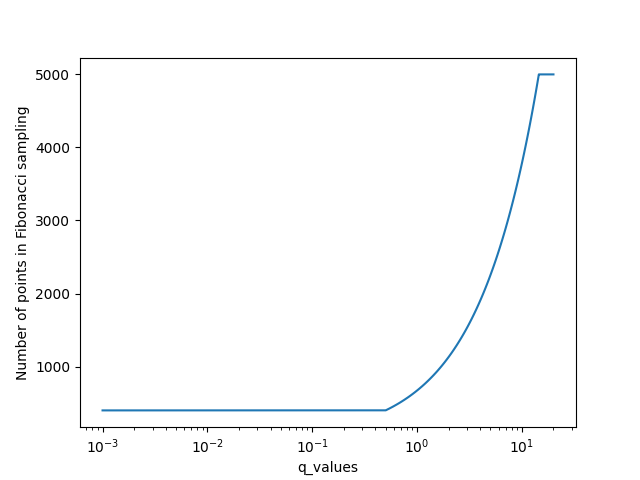

In [4]:

q_vals=np.arange(0.001,20,0.001)
plot_nbpoints_qvals(q_vals,n_base=400, q_ref=0.5, scaling_power=0.75,n_min=400, n_max=5000)

In [5]:
# Utilisation
path = "./compute_f0/elements_info.yaml"
table = load_elements_yaml(path)
element = "Au"    

f0_Q = f0_from_Q(q_vals, element, table)

# create a decahedron cluster
deca=Decahedron('Au',5,10,0)
positions=deca.get_positions()
nb_atoms=positions.shape[0]
print(f'Number of atoms in the cluster: {nb_atoms}')

# compute intensity using adaptative Fibonacci sampling
Iq = compute_isotropic_intensity_adaptative_fibonacci(positions, f0_Q, q_vals,n_base=400, q_ref=0.5, scaling_power=0.75,n_min=400, n_max=5000)

Number of atoms in the cluster: 564


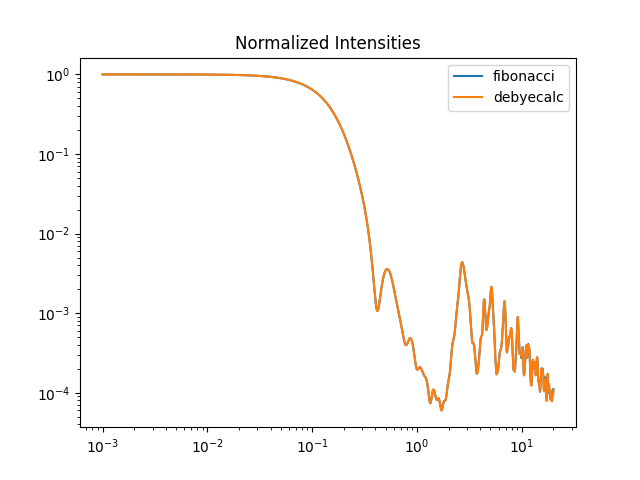

In [6]:
# computation using debyecalculator for comparison
from debyecalculator import DebyeCalculator
from ase.io import write

write('./testfib.xyz',deca)
calc = DebyeCalculator(qmin=0.001,qmax=20,qstep=0.001,biso=0,device='cpu')
q,i=calc.iq(structure_source='./testfib.xyz')
i*=2 # there is still a factor 2 difference somewhere... 
# perhaps debyecalculator sums over half of pairs (because pair (i,j) is equivalent to pair (j,i)?)

plt.figure()
plt.loglog(q_vals,Iq/Iq.max(),label='fibonacci')
plt.loglog(q,i/i.max(),label='debyecalc')
plt.title('Normalized Intensities')
plt.legend()


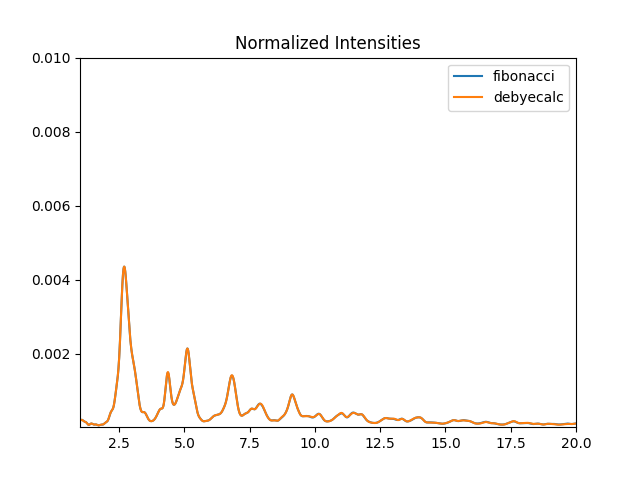

In [7]:
plt.figure()
plt.plot(q_vals,Iq/Iq.max(),label='fibonacci')
plt.plot(q,i/(i).max(),label='debyecalc')
plt.title('Normalized Intensities')
plt.xlim(1,20)
plt.ylim(1e-5,1e-2)
plt.legend()

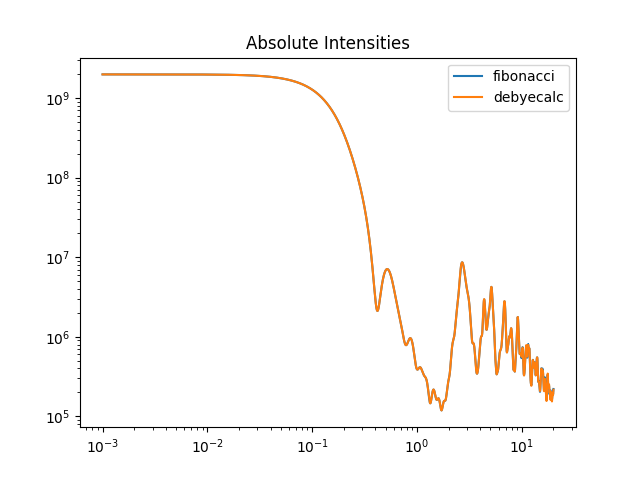

In [8]:

plt.figure()
plt.loglog(q_vals,Iq,label='fibonacci')
plt.loglog(q,(i),label='debyecalc')
plt.title('Absolute Intensities')
plt.legend()

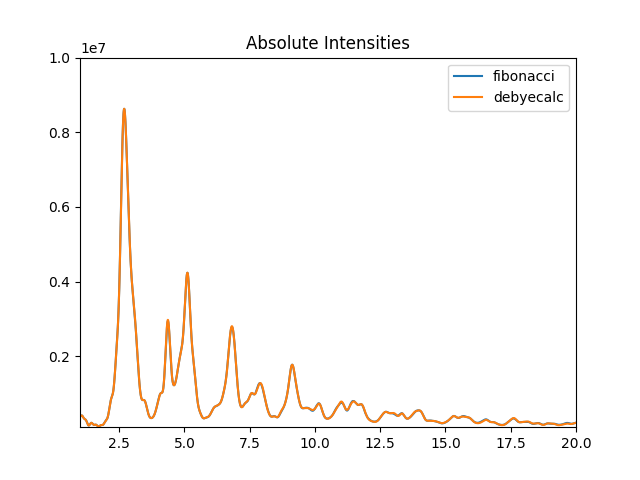

In [9]:
plt.figure()
plt.plot(q_vals,Iq,label='fibonacci')
plt.plot(q,(i),label='debyecalc')
plt.title('Absolute Intensities')
plt.xlim(1,20)
plt.ylim(1e5,1e7)
plt.legend()